<a href="https://colab.research.google.com/github/heitorabqg/datascientist/blob/master/PSI5892_pca_1207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# Análise de componentes principais (PCA) e análise de discriminantes lineares (LDA)

Neste exercício, você vai trabalhar com uma aplicação de redes neurais para  para a área de saúde. O objetivo é obter um modelo de predição de uma doença cardíaca baseado em dados com características extraídas de exames clínicos laboratoriais.

## Dados disponibilizados

Os dados para treinamento e teste do modelo estão disponíveis no formato CSV, em um arquivo zip disponível [neste link](./data.zip).

Após extrair os arquivos, utiliza a biblioteca Pandas para carregar os `DataFrames` `data_train` e `data_test`, como mostrado a seguir:

``` python
import pandas as pd

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])

data_test = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])
```

Os dados consistem de 800 exemplos de treinamento e 225 para teste, cada um contendo 13 características de entrada, representadas pelas colunas de 0 a 12 e a saída desejada binária, indicando se o paciente é portador ou não da doença, representada pela coluna 13.

O objetivo é treinar uma rede neural com estes dados, avaliar o desempenho e depois comparar com o desempenho obtido usando o PCA para realizar redução de dimensionalidade. Use como referência o exemplo mostrado [neste Jupyter Notebook](./PCA_IRIS.ipynb)

# Exercício 1

Implemente uma rede neural para classificar se o indivíduo é portador ou não da doença cardíaca (coluna 13) usando como entrada os dados dos exames laboratoriais (colunas 1 a 12). Calcule a acurácia obtida nos dados de teste.

## Resolução

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# 1. Carregar os dados
data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test  = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

# 2. Separar X e y
X_train = data_train.iloc[:, 0:13].values
y_train = data_train.iloc[:, 13].values

X_test = data_test.iloc[:, 0:13].values
y_test = data_test.iloc[:, 13].values

# 3. Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Rede Neural
mlp = MLPClassifier(
    hidden_layer_sizes=(20, 10),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)

# 5. Avaliação
y_pred = mlp.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("Acurácia no conjunto de teste:", accuracy)


Acurácia no conjunto de teste: 1.0


Usando dispositivo: cpu
Época 0 - Loss 0.9595
Época 200 - Loss 0.4573
Época 400 - Loss 0.3102
Época 600 - Loss 0.3876
Época 800 - Loss 0.2089
Época 1000 - Loss 0.2674
Época 1200 - Loss 0.3165
Época 1400 - Loss 0.1391
Época 1600 - Loss 0.1236
Época 1800 - Loss 0.1130


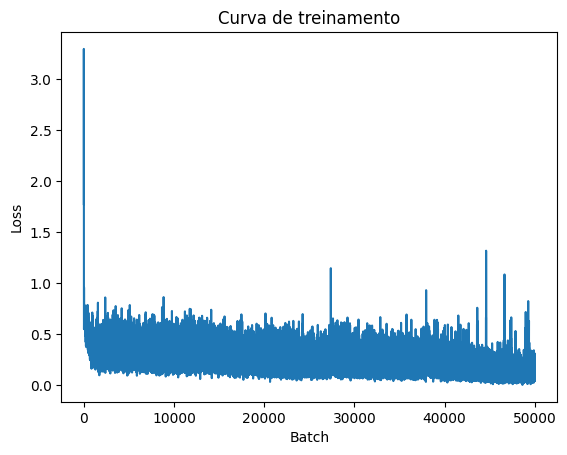

Acurácia no teste = 86.22%


0.8622221946716309

In [3]:
import torch
import torch.nn as nn
import torch.utils.data as data
import pandas as pd
import matplotlib.pyplot as plt


data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test  = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

dados_treino_np = data_train.values
dados_teste_np  = data_test.values


# Modelo com ReLU
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(12, 16),
            nn.ReLU(),

            nn.Linear(16, 12),
            nn.ReLU(),

            nn.Linear(12, 8),
            nn.ReLU(),

            nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.model(x)



def criar_dataloader(dados_np, Nb):
    dados = torch.tensor(dados_np, dtype=torch.float32)

    dataset = [
        (dados[i, 1:13], dados[i, 13].long())
        for i in range(dados.shape[0])
    ]

    loader = data.DataLoader(dataset, batch_size=Nb, shuffle=True)
    return loader


# Treino
def treino(model, train_loader, Ne, device):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()

    losses = []
    model.to(device)

    for epoch in range(Ne):
        for n, (X, d) in enumerate(train_loader):

            X, d = X.to(device), d.to(device)

            model.train()
            model.zero_grad()

            y = model(X)

            loss = loss_function(y, d)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        if epoch % 200 == 0:
            print(f"Época {epoch} - Loss {loss.item():.4f}")


    plt.figure()
    plt.plot(losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Curva de treinamento")
    plt.show()

    return losses


# Teste
def testar(model, dados_np, device):
    dados = torch.tensor(dados_np, dtype=torch.float32)

    X = dados[:, 1:13].to(device)
    y_true = dados[:, 13].long().to(device)

    model.eval()
    with torch.no_grad():
        logits = model(X)
        pred = torch.argmax(logits, dim=1)

    acc = (pred == y_true).float().mean().item()
    print(f"Acurácia no teste = {acc*100:.2f}%")

    return acc


# Execução
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando dispositivo:", device)

Nb = 32
Ne = 2000

train_loader = criar_dataloader(dados_treino_np, Nb)

model = Model()

# Treinar
losses = treino(model, train_loader, Ne, device)

# Testar
testar(model, dados_teste_np, device)


Usando dispositivo: cpu
Época 0 - Loss 0.6867
Época 200 - Loss 0.0083
Época 400 - Loss 0.0000
Época 600 - Loss 0.0000
Época 800 - Loss 0.0001
Época 1000 - Loss 0.0000
Época 1200 - Loss 0.0000
Época 1400 - Loss 0.0000
Época 1600 - Loss 0.0000
Época 1800 - Loss 0.0000


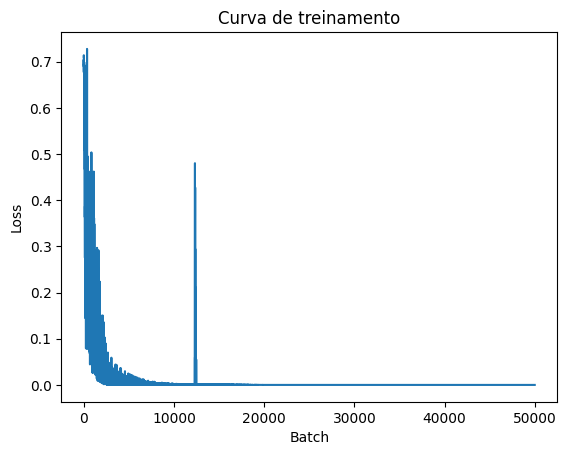

Acurácia no teste = 100.00%


1.0

In [5]:
import torch
import torch.nn as nn
import torch.utils.data as data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar dados
data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test  = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

dados_treino_np = data_train.values
dados_teste_np  = data_test.values


# Normalização dos dados de treino
X_train = dados_treino_np[:, 1:13]
X_test  = dados_teste_np[:, 1:13]

# Média e desvio do treino
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)

# Evita divisão por zero
std[std == 0] = 1.0

# Normaliza
X_train_norm = (X_train - mean) / std
X_test_norm  = (X_test  - mean) / std

# Recria os arrays completos normalizados (saída permanece a mesma)
dados_treino_norm = dados_treino_np.copy()
dados_treino_norm[:, 1:13] = X_train_norm

dados_teste_norm = dados_teste_np.copy()
dados_teste_norm[:, 1:13] = X_test_norm


# Modelo com ReLU
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(12, 16),
            nn.ReLU(),

            nn.Linear(16, 12),
            nn.ReLU(),

            nn.Linear(12, 8),
            nn.ReLU(),

            nn.Linear(8, 2)  # saída binária
        )

    def forward(self, x):
        return self.model(x)


# Dataloader
def criar_dataloader(dados_np, Nb):
    dados = torch.tensor(dados_np, dtype=torch.float32)

    dataset = [
        (dados[i, 1:13], dados[i, 13].long())
        for i in range(dados.shape[0])
    ]

    loader = data.DataLoader(dataset, batch_size=Nb, shuffle=True)
    return loader


# Treinamento
def treino(model, train_loader, Ne, device):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()

    losses = []
    model.to(device)

    for epoch in range(Ne):
        for n, (X, d) in enumerate(train_loader):

            X, d = X.to(device), d.to(device)

            model.train()
            model.zero_grad()

            y = model(X)
            loss = loss_function(y, d)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        if epoch % 200 == 0:
            print(f"Época {epoch} - Loss {loss.item():.4f}")

    plt.figure()
    plt.plot(losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Curva de treinamento")
    plt.show()

    return losses


# Teste
def testar(model, dados_np, device):
    dados = torch.tensor(dados_np, dtype=torch.float32)

    X = dados[:, 1:13].to(device)
    y_true = dados[:, 13].long().to(device)

    model.eval()
    with torch.no_grad():
        logits = model(X)
        pred = torch.argmax(logits, dim=1)

    acc = (pred == y_true).float().mean().item()
    print(f"Acurácia no teste = {acc*100:.2f}%")

    return acc


# Execução
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando dispositivo:", device)

Nb = 32
Ne = 2000

train_loader = criar_dataloader(dados_treino_norm, Nb)
model = Model()

losses = treino(model, train_loader, Ne, device)

testar(model, dados_teste_norm, device)


# Exercício 2

Aplique o PCA nos dados de entrada e obtenha uma matriz de dados transformados representando os 12 componentes principais. Mostre o valor da porcentagem de variância explicada acumulada à medida que você considera um maior número de componentes principais.

## Resolução

1 componentes: 22.07% da variância explicada
2 componentes: 33.49% da variância explicada
3 componentes: 42.89% da variância explicada
4 componentes: 52.00% da variância explicada
5 componentes: 59.85% da variância explicada
6 componentes: 67.39% da variância explicada
7 componentes: 74.05% da variância explicada
8 componentes: 79.92% da variância explicada
9 componentes: 85.39% da variância explicada
10 componentes: 90.01% da variância explicada
11 componentes: 93.94% da variância explicada
12 componentes: 97.20% da variância explicada


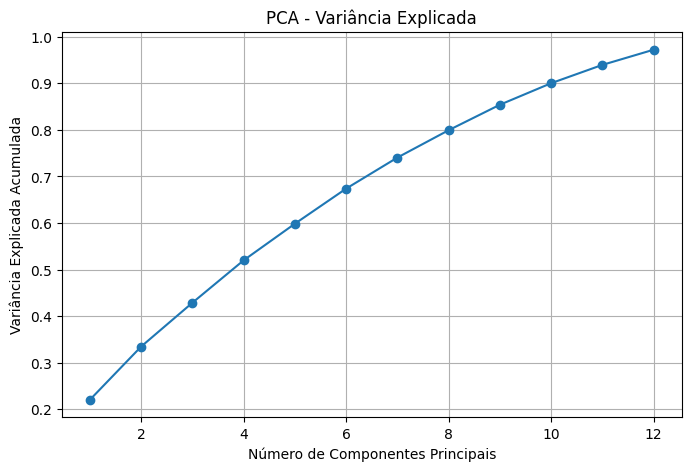

In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

for i, cv in enumerate(cumulative_variance, start=1):
    print(f"{i} componentes: {cv*100:.2f}% da variância explicada")

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,13), cumulative_variance, marker='o')
plt.xlabel("Número de Componentes Principais")
plt.ylabel("Variância Explicada Acumulada")
plt.title("PCA - Variância Explicada")
plt.grid(True)
plt.show()




In [6]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# 1. CARREGAR OS DADOS (12 variáveis de entrada + classe)
# ---------------------------------------------------------

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
dados = data_train.iloc[:, 1:13].values    # apenas as 12 features

# N = número de amostras, D = número de dimensões (12)
N, D = dados.shape


# ---------------------------------------------------------
# 2. NORMALIZAÇÃO (média 0, desvio 1) – Feita manualmente
# ---------------------------------------------------------

mean = np.mean(dados, axis=0)
std  = np.std(dados, axis=0)

std[std == 0] = 1  # evitar divisão por zero

X = (dados - mean) / std   # dados normalizados (X_n)


# ---------------------------------------------------------
# 3. CALCULAR A MATRIZ DE COVARIÂNCIA (12×12)
#    S = (1/N) * Σ (xn - x)(xn - x)^T
# ---------------------------------------------------------

S = (1/N) * (X.T @ X)

# S tem dimensão 12×12


# ---------------------------------------------------------
# 4. CALCULAR AUTOVALORES E AUTOVETORES DE S
#    Su = λu
# ---------------------------------------------------------

autovalores, autovetores = np.linalg.eig(S)

# autovalores → variâncias explicadas por cada componente
# autovetores → vetores principais (u_k)


# ---------------------------------------------------------
# 5. ORDENAR AUTOVALORES E AUTOVETORES EM ORDEM DECRESCENTE
# ---------------------------------------------------------

idx = np.argsort(autovalores)[::-1]

autovalores = autovalores[idx]
autovetores = autovetores[:, idx]


# ---------------------------------------------------------
# 6. MATRIZ DOS COMPONENTES PRINCIPAIS (U = autovetores)
#    Usaremos todos os 12 componentes
# ---------------------------------------------------------

U = autovetores   # 12×12


# ---------------------------------------------------------
# 7. PROJETAR OS DADOS NO NOVO ESPAÇO
#    P = U^T * X
# ---------------------------------------------------------

P = U.T @ X.T     # resultado: 12×N
P = P.T           # agora N×12 (cada linha = nova representação do dado)


# ---------------------------------------------------------
# 8. CÁLCULO DA VARIÂNCIA EXPLICADA
# ---------------------------------------------------------

variancia_total = np.sum(autovalores)
variancia_explicada = autovalores / variancia_total

variancia_acumulada = np.cumsum(variancia_explicada)


# ---------------------------------------------------------
# 9. MOSTRAR RESULTADOS
# ---------------------------------------------------------

print("\nAUTOVALORES (variância de cada componente):\n", autovalores)
print("\nPROPORÇÃO DA VARIÂNCIA EXPLICADA:\n", variancia_explicada)
print("\nVARIÂNCIA ACUMULADA:\n", variancia_acumulada)

print("\nMatriz transformada P (primeiros 5 exemplos):\n", P[:5, :])



AUTOVALORES (variância de cada componente):
 [2.67825659 1.34831784 1.21824762 1.18287334 0.99750647 0.93871795
 0.82047676 0.76039342 0.60310732 0.56333114 0.50852119 0.38025036]

PROPORÇÃO DA VARIÂNCIA EXPLICADA:
 [0.22318805 0.11235982 0.10152064 0.09857278 0.08312554 0.0782265
 0.06837306 0.06336612 0.05025894 0.04694426 0.04237677 0.03168753]

VARIÂNCIA ACUMULADA:
 [0.22318805 0.33554787 0.4370685  0.53564128 0.61876682 0.69699332
 0.76536638 0.8287325  0.87899144 0.9259357  0.96831247 1.        ]

Matriz transformada P (primeiros 5 exemplos):
 [[ 0.42058336  1.3181502  -0.96628502  1.22199848 -0.43826073 -1.44085346
  -0.34250738 -0.45935023  0.56276181  0.54485527 -0.49622503 -0.0639727 ]
 [-2.90900395 -0.60219352 -1.28004295 -1.05424145 -0.11601814  1.34008421
   1.73149576  0.18128941  1.4766462   1.32503317 -0.40587423  0.22671855]
 [-2.74756772  1.55140817  0.01288907 -1.68063732 -0.9684708   0.2040404
   1.12169744 -0.92137564  0.45390368 -0.0391658  -0.23221982  0.6753212

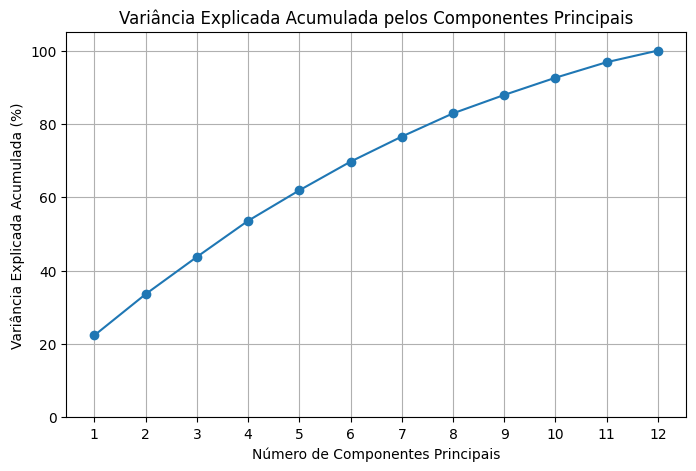

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Número de componentes (1 até 12)
num_componentes = np.arange(1, len(variancia_acumulada) + 1)

plt.figure(figsize=(8, 5))
plt.plot(num_componentes, variancia_acumulada * 100, marker='o')
plt.title("Variância Explicada Acumulada pelos Componentes Principais")
plt.xlabel("Número de Componentes Principais")
plt.ylabel("Variância Explicada Acumulada (%)")
plt.grid(True)
plt.xticks(num_componentes)
plt.ylim(0, 105)

plt.show()

# Exercício 3

Implemente uma segunda rede neural para fazer a classificação usando o número de componentes principais necessário para incluir 90% da variância explicada. Calcule a acurácia obtida nos dados de teste.

## Resolução

In [ ]:
pca_full = PCA(n_components=13)
pca_full.fit(X_train_scaled)

explained = np.cumsum(pca_full.explained_variance_ratio_)


n_components_90 = np.argmax(explained >= 0.90) + 1
print("Número de componentes para atingir 90% da variância:", n_components_90)


pca = PCA(n_components=n_components_90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


mlp_pca = MLPClassifier(
    hidden_layer_sizes=(20, 10),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

mlp_pca.fit(X_train_pca, y_train)


y_pred_pca = mlp_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print("Acurácia no teste usando PCA (90% variância):", accuracy_pca)


Número de componentes para atingir 90% da variância: 10
Acurácia no teste usando PCA (90% variância): 0.9866666666666667


# Exercício 4

Repita os exercícios 1, 2 e 3, considerando a transformação dos dados usando o LDA no lugar do PCA. Use como referência o exemplo mostrado [neste Jupyter Notebook](./LDA_IRIS.ipynb)

## Resolução

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

mlp_orig = MLPClassifier(
    hidden_layer_sizes=(20,10),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
mlp_orig.fit(X_train_scaled, y_train)

pred_orig = mlp_orig.predict(X_test_scaled)
acc_orig = accuracy_score(y_test, pred_orig)

print("Acurácia com dados originais:", acc_orig)


lda = LinearDiscriminantAnalysis(n_components=1)  # para 2 classes
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda  = lda.transform(X_test_scaled)



eigenvalues = lda.explained_variance_ratio_
print("Variância explicada pelo discriminante:", eigenvalues[0])


mlp_lda = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

mlp_lda.fit(X_train_lda, y_train)

pred_lda = mlp_lda.predict(X_test_lda)
acc_lda = accuracy_score(y_test, pred_lda)

print("Acurácia usando LDA:", acc_lda)




Acurácia com dados originais: 1.0
Variância explicada pelo discriminante: 1.0
Acurácia usando LDA: 0.7866666666666666
